In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
from reload_recursive import reload_recursive
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
import sys

from mri_data import file_manager as fm
import helpers

In [2]:
reload_recursive(helpers)

### Paths and Config

In [3]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
pd.options.display.precision = 3
colors = helpers.get_colors()

### Load and Prepare Data

In [4]:
df = pd.read_csv(data_dir / "t1_aschoplex_data_full.csv", index_col="subid")
df_full = df.copy()
df_tmp = pd.read_csv(data_dir / "t1_data_full.csv", index_col="subid")
df['pineal_volume'] = df_tmp['pineal_volume']
df['pituitary_volume'] = df_tmp['pituitary_volume']

df = helpers.get_mri_edss_delta(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dzdur",
    "extracted_EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_mri_delta",
    "edss_date_closest",
    "mri_date_closest",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]
df = df.loc[:, keep_cols]

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)
df = helpers.norm_volumes(df)

df.rename(columns={"lesion_vol_cubic": "t2lv"}, inplace=True)
df = df.rename(columns={"extracted_EDSS": "EDSS"})

df = helpers.do_sqrt_transform(df, ["EDSS", "MSSS", "ARMSS", "gMSSS"])
df = helpers.do_log_transform(df, ["t2lv"])

vars_to_center = ["EDSS_sqrt", "t2lv_logtrans", "t2lv", "dzdur", "choroid_volume", "PRL"]
df = helpers.do_center(df, vars_to_center)

vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "t2lv",
    "t2lv_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
    "thalamus"
]
df = helpers.do_scale(df, vars_to_scale)

numeric_vars = [
    "age",
    "dzdur",
    "Female",
    "EDSS", "EDSS_sqrt",
    "MSSS", "MSSS_sqrt",
    "gMSSS", "gMSSS_sqrt",
    "ARMSS", "ARMSS_sqrt",
    "edss_mri_delta",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "t2lv", "t2lv_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
    "norm_choroid_volume",
    "pineal_volume",
    "pituitary_volume"
]

for var in numeric_vars:
    df[var] = df[var].astype("float")

df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale = df.copy() #temporary till I rename df_scale everywehre
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[numeric_vars].astype("float")
df_z[df.columns[~df.columns.isin(numeric_vars)]] = df[df.columns[~df.columns.isin(numeric_vars)]]
df_z = df_z[df.columns]
df_z[numeric_vars] = df_z[numeric_vars].apply(stats.zscore, nan_policy="omit")

# delete these vars once I fix all future variable references
data = df[numeric_vars].astype("float")
data_z = data[numeric_vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[numeric_vars].astype("float")
data_ms_z = data_ms[numeric_vars].apply(stats.zscore, nan_policy="omit")

In [5]:
columns = [
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "age",
    "sex",
    "tiv",
    "flair_contrast",
    "EDSS",
    "ARMSS",
    "PRL",
    "t2lv",
    "MSSS",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "thalamus",
    "brain",
    "cortical_thickness",
    "dzdur",
]
df_jasp = df[columns]
df_jasp = pd.concat((df_jasp, pd.get_dummies(df_jasp["sex"])), axis=1)
df_jasp = df_jasp.loc[df_jasp["dzdur"] != ".", :]

for i, row in df_jasp.iterrows():
    if row["Female"]:
        df_jasp.loc[i, "Female"] = 1
    else:
        df_jasp.loc[i, "Female"] = 0

    if row["Male"]:
        df_jasp.loc[i, "Male"] = 1
    else:
        df_jasp.loc[i, "Male"] = 0

/tmp/ipykernel_1585/3612060522.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, "Female"] = 1
/tmp/ipykernel_1585/3612060522.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, "Male"] = 0


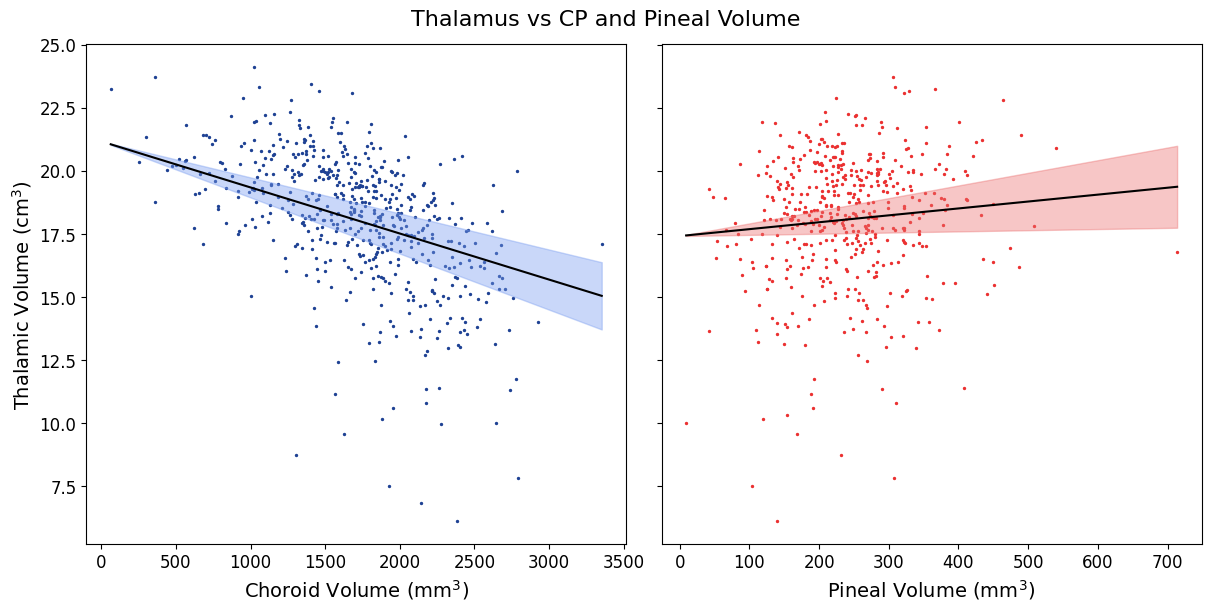

In [32]:
outcome = "thalamus"
covariates = "age + Female + tiv"

fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained', sharey=True, facecolor=(1, 1, 1, 0.5))
fig.suptitle("Thalamus vs CP and Pineal Volume", fontsize=16)
fig.patch.set_alpha(0)

ax = axs[0]
# ax.set_title("Choroid Plexus Volume")
formula = f"{outcome} ~ choroid_volume + {covariates}"
res = sm.OLS.from_formula(formula, data=data).fit()
x, y_pred, y_lims = helpers.get_regression_y(data, res, "choroid_volume", outcome)
ax.scatter(data['choroid_volume'], data[outcome], s=2, color=colors['dark blue1'], label="Choroid Plexus")
ax.plot(x, y_pred, color='black')
ax.fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=colors['light blue1'])
ax.set_ylabel("Thalamic Volume (cm$^{3}$)", fontsize=14)
ax.set_xlabel("Choroid Volume (mm$^{3}$)", fontsize=14)
ax.tick_params("y", labelsize=12)
ax.tick_params("x", labelsize=12)

ax = axs[1]
# ax.set_title("Pineal Volume")
pin_data = data.copy()
pin_data = pin_data[data_z['pineal_volume'] < 5]
formula = f"{outcome} ~ pineal_volume + {covariates}"
res = sm.OLS.from_formula(formula, data=pin_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(pin_data, res, "pineal_volume", outcome)
ax.scatter(pin_data['pineal_volume'], pin_data[outcome], s=2, color=colors['dark red1'], label="Pineal Gland")
ax.plot(x, y_pred, color='black')
ax.fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=colors['light red1'])
# ax.set_ybound([0, 6])
ax.set_xlabel("Pineal Volume (mm$^{3}$)", fontsize=14)
ax.tick_params("x", labelsize=12)

plt.savefig("/home/srs-9/Projects/ms_mri/analysis/paper1/figures/thalamus.png", transparent=True)

# fig.legend(loc=4, bbox_to_anchor=(0.98, 0.15), fontsize=12,
#            markerscale=5)

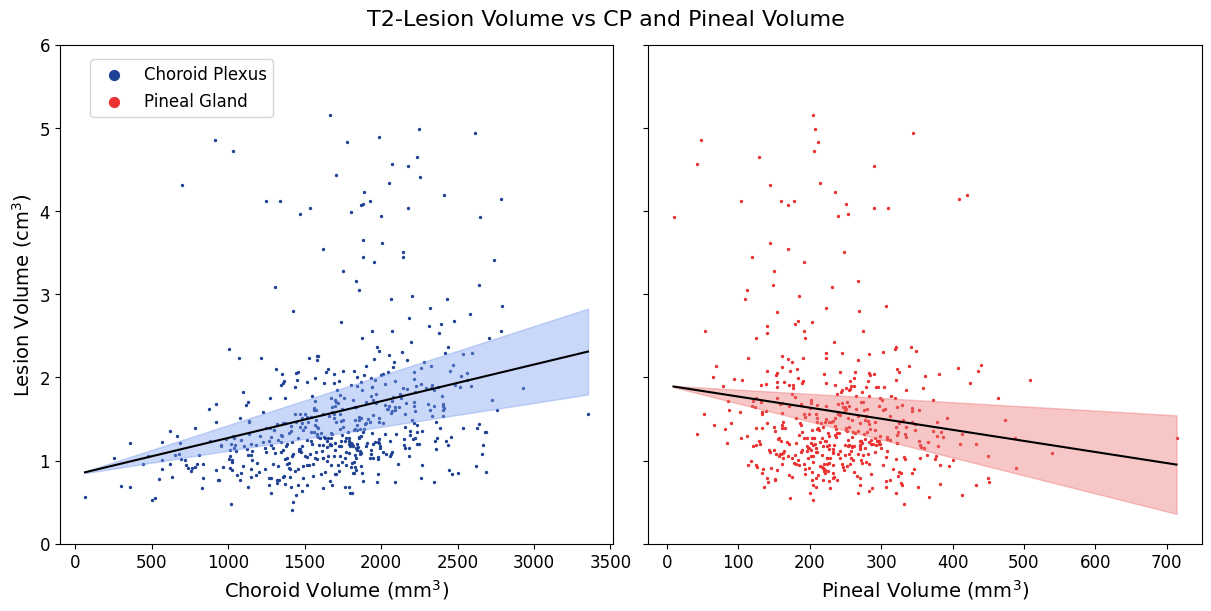

In [31]:
outcome = "t2lv"
covariates = "age + Female + tiv"

fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained', sharey=True, facecolor=(1, 1, 1, 0.5))
fig.suptitle("T2-Lesion Volume vs CP and Pineal Volume", fontsize=16)
fig.patch.set_alpha(0)

ax = axs[0]
# ax.set_title("Choroid Plexus Volume")
formula = f"{outcome} ~ choroid_volume + {covariates}"
res = sm.OLS.from_formula(formula, data=data).fit()
x, y_pred, y_lims = helpers.get_regression_y(data, res, "choroid_volume", outcome)
ax.scatter(data['choroid_volume'], data[outcome], s=2, color=colors['dark blue1'], label="Choroid Plexus")
ax.plot(x, y_pred, color='black')
ax.fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=colors['light blue1'])
ax.set_ylabel("Lesion Volume (cm$^{3}$)", fontsize=14)
ax.set_xlabel("Choroid Volume (mm$^{3}$)", fontsize=14)
ax.tick_params("y", labelsize=12)
ax.tick_params("x", labelsize=12)
ax.set_ybound([0, 6])

ax = axs[1]
# ax.set_title("Pineal Volume")
pin_data = data.copy()
pin_data = pin_data[data_z['pineal_volume'] < 5]
formula = f"{outcome} ~ pineal_volume + {covariates}"
res = sm.OLS.from_formula(formula, data=pin_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(pin_data, res, "pineal_volume", outcome)
ax.scatter(pin_data['pineal_volume'], pin_data[outcome], s=2, color=colors['dark red1'], label="Pineal Gland")
ax.plot(x, y_pred, color='black')
ax.fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=colors['light red1'])
ax.set_ybound([0, 6])
ax.set_xlabel("Pineal Volume (mm$^{3}$)", fontsize=14)
ax.tick_params("x", labelsize=12)

fig.legend(loc=4, bbox_to_anchor=(0.23, 0.80), fontsize=12,
           markerscale=5)

plt.savefig("/home/srs-9/Projects/ms_mri/analysis/paper1/figures/t2lv.png", transparent=True)